# STAT 6650: Homework 3
Samarth Kumar (szk0187)

---

## Question 1
So far, I've learned about various Machine Learning and Statistical concepts. From linear regression (normal equations and gradient descent), logistic regression, along with regularization (ridge/lasso), to cross validation techniques, concepts of overfitting, bias, variance. And even later concepts, like KNN, K-Means clustering, trees, SVMs, neural networks, and more.

I've noticed how every topic intersects. For example, gradient descent, although we originally learned this in relation to linear or logistic regression, is actually a very important concept, as gradient descent is used for updating the parameters of a neural network. Additionally, cross validation techniques (K-fold, LOOCV) and regularization are also quite important in preventing overfitting.
And for this assignment, specifically, the concept of

Perceptron feels like a linear regression algorithm in some ways, as this also involves a linear combination of weights and biases. Both are good for linearly separable data. However, perceptron works differently, as it penalizes incorrect predictions, thus being better at capturing more complex relationships. Additionally, perceptron is for binary classification instead of predicting continuous outcomes.

I understand how all of these topics could apply towards real-world scenarios.

I wouldn't say any topic in particular is too difficult, but Support Vector Machine (SVM) was the hardest one for me to grasp, when it comes to kernel trick, and other concepts.

Import dependencies

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

## Question 2

### (a) Building the Pseudo Random Forest

In [2]:
class RandomForest:
    def __init__(self, nest=10, maxDepth=None, minSamplesLeaf=1, q=None, randomState=None):
        # The main parameters to experiment with.
        self.nest = nest
        self.maxDepth = maxDepth
        self.minSamplesLeaf = minSamplesLeaf
        self.q = q

        self.randomState = randomState

        # Store the trees, feature subsets, indices for bootstrap samples.
        self.trees = []
        self.featureSets = []
        self.bootstrapValues = []

    # Train the random forest.
    def fit(self, X, y):
        np.random.seed(self.randomState)

        self.trees = []
        self.featureSets = []
        self.bootstrapValues = []

        numSamples, numFeatures = X.shape

        # Default q would be the square root of the # of features, if not given.
        self.q = int(np.sqrt(numFeatures)) if self.q != None else self.q

        for i in range(self.nest):
            # Define a random subspace of features.
            featureIndex = np.random.choice(numFeatures, self.q, replace=False)
            sampleIndex = np.random.choice(numSamples, numSamples, replace=True)
            self.bootstrapValues.append(sampleIndex)
            xBoot = X[sampleIndex][:, featureIndex]
            yBoot = y[sampleIndex]

            # Train a decision tree to the bootstrapped data.
            tree = DecisionTreeClassifier(
                max_depth=self.maxDepth,
                min_samples_leaf=self.minSamplesLeaf,
                random_state=self.randomState
            )
            tree.fit(xBoot, yBoot)
            self.trees.append(tree)
            self.featureSets.append(featureIndex)

    # Create predictions.
    def predict(self, X):
        predictions = []
        for i, tree in enumerate(self.trees):
            featureIndex = self.featureSets[i]
            X_sub = X[:, featureIndex]
            preds = tree.predict(X_sub)
            predictions.append(preds)

        predictions = np.array(predictions).T

        # Take the majority vote for every sample.
        finalPredictions = []
        for row in predictions:
            vote = np.bincount(row).argmax()
            finalPredictions.append(vote)

        return np.array(finalPredictions)

Out-of-bag (OOB) Accuracy

In [3]:
def oob_accuracy(model, X, y):
    numSamples = X.shape[0]
    votes = [[] for _ in range(numSamples)]

    for tree_idx, tree in enumerate(model.trees):
        boot_indices = set(model.bootstrapValues[tree_idx])
        feat_idx = model.featureSets[tree_idx]

        # For each sample, if it was not used to train this tree, get a prediction.
        for i in range(numSamples):
            if i not in boot_indices:
                sample_pred = tree.predict(X[i, feat_idx].reshape(1, -1))
                votes[i].append(sample_pred[0])

    # Compute OOB accuracy for samples with >= 1 vote.
    samples, correct = 0, 0
    for i in range(numSamples):
        if len(votes[i]) > 0:
            samples += 1
            vote = np.bincount(votes[i]).argmax()
            if vote == y[i]:
                correct += 1

    return correct / samples if samples != 0 else 0.0

Feature importance

In [4]:
def feature_importance(model, num_features):
    importances = np.zeros(num_features)
    for tree, featureIndex in zip(model.trees, model.featureSets):
        treeImportances = tree.feature_importances_
        for idx, imp in zip(featureIndex, treeImportances):
            importances[idx] += imp

    # Normalize the importances.
    importances /= len(model.trees)
    return importances

Preprocessing

In [5]:
def preprocess(fileName):
    df = pd.read_csv(fileName)
    df.drop('ID', axis=1, inplace=True)

    # For missing values.
    for col in df.columns:
        # Use the modes for text values.
        if df[col].dtype == 'object':
            mode_val = df[col].mode()[0]
            df[col] = df[col].fillna(mode_val)
        # Use the means for numerical values.
        else:
            mean_val = df[col].mean()
            df[col] = df[col].fillna(mean_val)

    # Using label encoding so that we use integer values for categorical features.
    categories = [c for c in df.columns if df[c].dtype == 'object']
    for c in categories:
        le = LabelEncoder()
        df[c] = le.fit_transform(df[c])

    # Separate features & target.
    X = df.drop('Status', axis=1).values
    y = df['Status'].values

    # Split training and test data.
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    return X_train, X_test, y_train, y_test

In [7]:
X_train, X_test, y_train, y_test = preprocess("Loan_Default.csv")

### (b) Find best parameters for maxDepth, minSamplesLeaf and q

### Downloading the data (Using provided code from canvas announcement)

First, defining a function that will loop through different combinations of maxDepth, minSamplesLeaf, and q values for a given value of nest.

In [8]:
def experiment(nest,
               maxDepthVals = [5,10,15,20,25],
               minSamplesLeafVals = [1,5,10],
               qVals = [2, 4, 8]):

    # Create a list to store the results.
    results = []

    # Iterate over different maxDepth, minSamplesLeaf, and q values.
    for maxDepth in maxDepthVals:
        for minSamplesLeaf in minSamplesLeafVals:
            for q in qVals:
                # Train a model with current parameters.
                model = RandomForest(
                    nest=nest, maxDepth=maxDepth,
                    minSamplesLeaf=minSamplesLeaf,
                    q=q,
                    randomState=42
                )
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                accuracy = accuracy_score(y_test, y_pred)
                results.append((nest, maxDepth, minSamplesLeaf, q, accuracy))

    # In the format of (nest, maxDepth, minSamplesLeaf, q, accuracy)
    return results

For nest = 5

Results for 5 trees:
Top 5 Results:
Nest: 5, Max Depth: 5, Min Samples Leaf: 1, q: 2, Accuracy: 0.9995291585390462
Nest: 5, Max Depth: 5, Min Samples Leaf: 1, q: 4, Accuracy: 0.9995291585390462
Nest: 5, Max Depth: 5, Min Samples Leaf: 1, q: 8, Accuracy: 0.9995291585390462
Nest: 5, Max Depth: 5, Min Samples Leaf: 5, q: 2, Accuracy: 0.9995291585390462
Nest: 5, Max Depth: 5, Min Samples Leaf: 5, q: 4, Accuracy: 0.9995291585390462


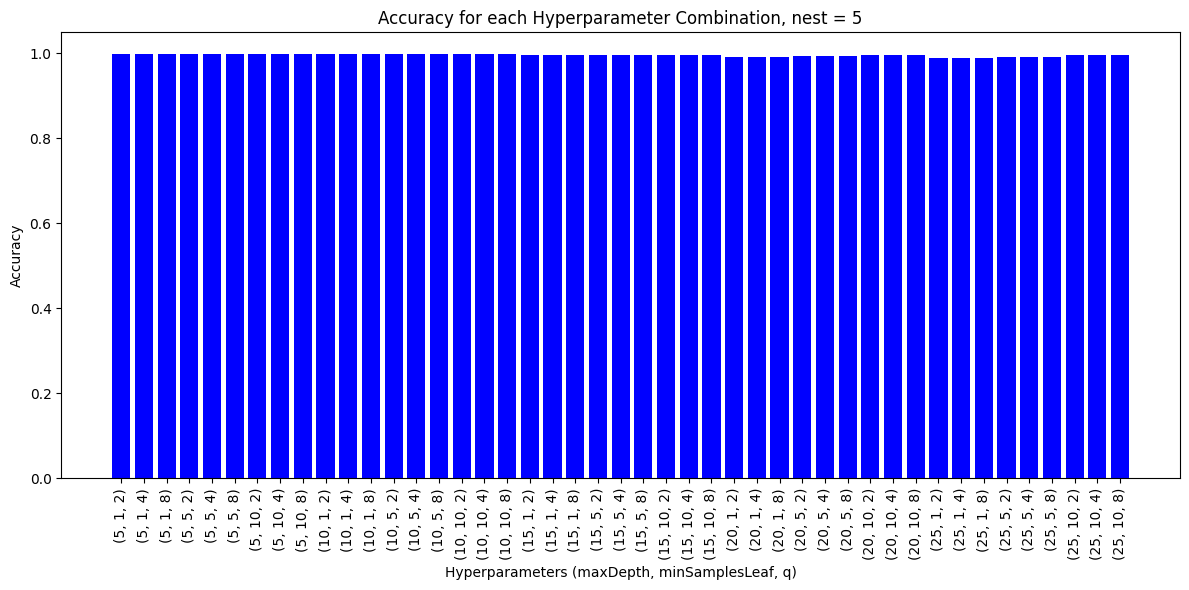

In [9]:
results5 = experiment(5)
print("Results for 5 trees:")

# Show the top 5 results by accuracy in descending order.
sortedResults5 = sorted(results5, key=lambda x: x[4], reverse=True)
print("Top 5 Results:")
for result in sortedResults5[:5]:
    print(f"Nest: {result[0]}, Max Depth: {result[1]}, Min Samples Leaf: {result[2]}, q: {result[3]}, Accuracy: {result[4]}")

labels = [f"({maxDepth}, {minSamplesLeaf}, {q})"
          for nest, maxDepth, minSamplesLeaf, q, _ in results5]
accuracies = [acc for *_, acc in results5]

# Create the bar plot.
plt.figure(figsize=(12, 6))
plt.bar(range(len(accuracies)), accuracies, color="blue")
plt.xticks(range(len(accuracies)), labels, rotation=90)
plt.xlabel("Hyperparameters (maxDepth, minSamplesLeaf, q)")
plt.ylabel("Accuracy")
plt.title("Accuracy for each Hyperparameter Combination, nest = 5")
plt.tight_layout()
plt.show()

For nest = 15

Results for 15 trees:
Top 5 Results:
Nest: 15, Max Depth: 25, Min Samples Leaf: 5, q: 2, Accuracy: 0.8678617071366113
Nest: 15, Max Depth: 25, Min Samples Leaf: 5, q: 4, Accuracy: 0.8678617071366113
Nest: 15, Max Depth: 25, Min Samples Leaf: 5, q: 8, Accuracy: 0.8678617071366113
Nest: 15, Max Depth: 25, Min Samples Leaf: 1, q: 2, Accuracy: 0.867828075603686
Nest: 15, Max Depth: 25, Min Samples Leaf: 1, q: 4, Accuracy: 0.867828075603686


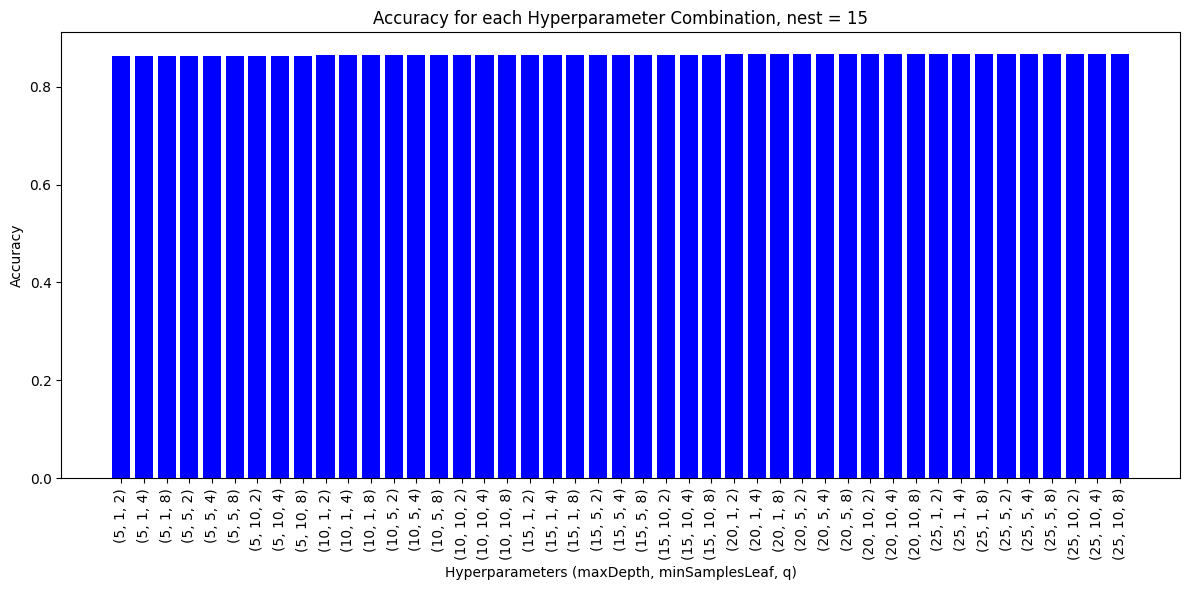

In [10]:
results15 = experiment(15)
print("Results for 15 trees:")

# Show the top 5 results by accuracy in descending order.
sortedResults15 = sorted(results15, key=lambda x: x[4], reverse=True)
print("Top 5 Results:")
for result in sortedResults15[:5]:
    print(f"Nest: {result[0]}, Max Depth: {result[1]}, Min Samples Leaf: {result[2]}, q: {result[3]}, Accuracy: {result[4]}")

labels = [f"({maxDepth}, {minSamplesLeaf}, {q})"
          for nest, maxDepth, minSamplesLeaf, q, _ in results15]
accuracies = [acc for *_, acc in results15]

# Create the bar plot.
plt.figure(figsize=(12, 6))
plt.bar(range(len(accuracies)), accuracies, color="blue")
plt.xticks(range(len(accuracies)), labels, rotation=90)
plt.xlabel("Hyperparameters (maxDepth, minSamplesLeaf, q)")
plt.ylabel("Accuracy")
plt.title("Accuracy for each Hyperparameter Combination, nest = 15")
plt.tight_layout()
plt.show()

For nest = 25

Results for 25 trees:
Top 5 Results:
Nest: 25, Max Depth: 25, Min Samples Leaf: 1, q: 2, Accuracy: 0.8687697585255936
Nest: 25, Max Depth: 25, Min Samples Leaf: 1, q: 4, Accuracy: 0.8687697585255936
Nest: 25, Max Depth: 25, Min Samples Leaf: 1, q: 8, Accuracy: 0.8687697585255936
Nest: 25, Max Depth: 25, Min Samples Leaf: 5, q: 2, Accuracy: 0.867828075603686
Nest: 25, Max Depth: 25, Min Samples Leaf: 5, q: 4, Accuracy: 0.867828075603686


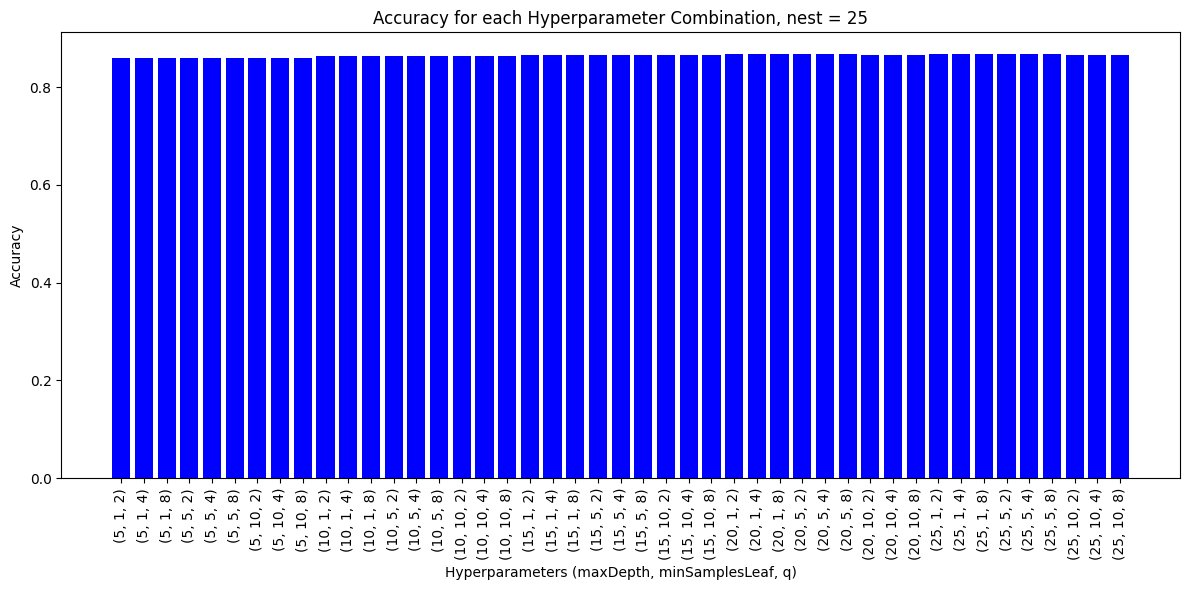

In [11]:
results25 = experiment(25)
print("Results for 25 trees:")

# Show the top 5 results by accuracy in descending order.
sortedResults25 = sorted(results25, key=lambda x: x[4], reverse=True)
print("Top 5 Results:")
for result in sortedResults25[:5]:
    print(f"Nest: {result[0]}, Max Depth: {result[1]}, Min Samples Leaf: {result[2]}, q: {result[3]}, Accuracy: {result[4]}")

labels = [f"({maxDepth}, {minSamplesLeaf}, {q})"
          for nest, maxDepth, minSamplesLeaf, q, _ in results25]
accuracies = [acc for *_, acc in results25]

# Create the bar plot.
plt.figure(figsize=(12, 6))
plt.bar(range(len(accuracies)), accuracies, color="blue")
plt.xticks(range(len(accuracies)), labels, rotation=90)
plt.xlabel("Hyperparameters (maxDepth, minSamplesLeaf, q)")
plt.ylabel("Accuracy")
plt.title("Accuracy for each Hyperparameter Combination, nest = 25")
plt.tight_layout()
plt.show()

Taking the best combinations for each nest (5, 15, 25)

Best Combination of maxDepth, minSamplesLeaf, q:
(5, 5, 1, 2, 0.9995291585390462)


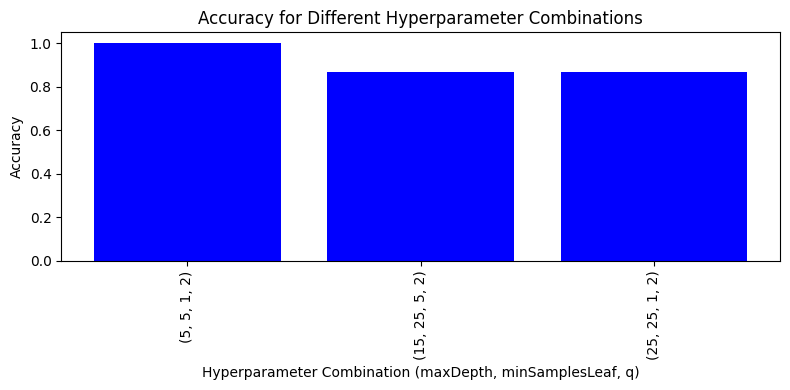

In [12]:
combinedResults = results5 + results15 + results25
sortedCombinedResults = sorted(combinedResults, key=lambda x: x[4], reverse=True)
print("Best Combination of maxDepth, minSamplesLeaf, q:")
print(sortedCombinedResults[0])

test = [
    sortedResults5[0], sortedResults15[0], sortedResults25[0]
]

x_values = range(len(test))
acc_values = [t[-1] for t in test]
labels = [f"({t[0]}, {t[1]}, {t[2]}, {t[3]})" for t in test]

plt.figure(figsize=(8, 4))
plt.bar(x_values, acc_values, color="blue")
plt.xticks(x_values, labels, rotation=90)
plt.xlabel("Hyperparameter Combination (maxDepth, minSamplesLeaf, q)")
plt.ylabel("Accuracy")
plt.title("Accuracy for Different Hyperparameter Combinations")
plt.tight_layout()
plt.show()

So the best combination is:
* nest = 5
* maxDepth = 5
* minSamplesLeaf = 1
* q = 2

### (c) Use optimal parameters to determine model performance

In [13]:
model = RandomForest(
    nest=5,
    maxDepth=5,
    minSamplesLeaf=1,
    q=2,
    randomState=42
)

In [14]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [15]:
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.9995291585390462


In [16]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22494
           1       1.00      1.00      1.00      7240

    accuracy                           1.00     29734
   macro avg       1.00      1.00      1.00     29734
weighted avg       1.00      1.00      1.00     29734



In [17]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Confusion Matrix:
[[22492     2]
 [   12  7228]]


In [18]:
# Compute and print the OOB accuracy using the training set.
oobAcc = oob_accuracy(model, X_train, y_train)
print("OOB Accuracy:", oobAcc)

OOB Accuracy: 0.9049752174319649


Overall, the random forest model performs quite well.

The accuracy on the test set (0.9995) is greater than the OOB Accuracy of 0.9050

### (d) Most Important Features

In [19]:
# Get the feature importances from the function I defined.
num_features = X_train.shape[1]
featureImportances = feature_importance(model, num_features)

# Get the feature names.
df = pd.read_csv("Loan_Default.csv")
df.drop(['ID', 'Status'], axis=1, inplace=True)
feature_names = df.columns.tolist()

# Sort the values.
sortedIdx = np.argsort(featureImportances)[::-1]

print("Ranking features by Importance:")
for i in sortedIdx:
    print(f"{feature_names[i]}: {featureImportances[i]:.4f}")

Ranking features by Importance:
Upfront_charges: 0.3964
Interest_rate_spread: 0.2000
property_value: 0.1957
lump_sum_payment: 0.1004
co-applicant_credit_type: 0.0564
loan_type: 0.0285
loan_purpose: 0.0091
Region: 0.0062
business_or_commercial: 0.0036
credit_type: 0.0023
income: 0.0007
loan_amount: 0.0005
Credit_Score: 0.0001
interest_only: 0.0000
loan_limit: 0.0000
dtir1: 0.0000
occupancy_type: 0.0000
construction_type: 0.0000
total_units: 0.0000
Secured_by: 0.0000
LTV: 0.0000
Security_Type: 0.0000
age: 0.0000
submission_of_application: 0.0000
rate_of_interest: 0.0000
term: 0.0000
Neg_ammortization: 0.0000
Credit_Worthiness: 0.0000
open_credit: 0.0000
approv_in_adv: 0.0000
Gender: 0.0000
year: 0.0000


The most important features (For this question, I'm considering features with importances at or exceeding 0.1 to be the most important, as majority of the features are even smaller than 0.01):
* Upfront charges
* Interest rate spread
* Property Value
* Lump sum payment

## Question 3

In [31]:
from os import makedirs, path, remove, rename, rmdir
from tarfile import open as open_tar
from urllib import request, parse

def download_corpus(dataset_dir: str = r'spam_data'):
    base_url = 'https://spamassassin.apache.org'
    corpus_path = 'old/publiccorpus'
    files = {
        '20021010_easy_ham.tar.bz2': 'ham',
        '20021010_hard_ham.tar.bz2': 'ham',
        '20021010_spam.tar.bz2': 'spam',
        '20030228_easy_ham.tar.bz2': 'ham',
        '20030228_easy_ham_2.tar.bz2': 'ham',
        '20030228_hard_ham.tar.bz2': 'ham',
        '20030228_spam.tar.bz2': 'spam',
        '20030228_spam_2.tar.bz2': 'spam',
        '20050311_spam_2.tar.bz2': 'spam'
    }

    # Prepare directory structure
    downloads_dir = path.join(dataset_dir, 'data')
    ham_dir = path.join(dataset_dir, 'ham')
    spam_dir = path.join(dataset_dir, 'spam')

    makedirs(downloads_dir, exist_ok=True)
    makedirs(ham_dir, exist_ok=True)
    makedirs(spam_dir, exist_ok=True)

    for file, spam_or_ham in files.items():
        # Construct download URL and local path
        url = parse.urljoin(base_url, f'{corpus_path}/{file}')
        tar_filename = path.join(downloads_dir, file)

        # Download the tar.bz2 file
        request.urlretrieve(url, tar_filename)
        print(f"Downloaded {file} -> {tar_filename}")

        with open_tar(tar_filename) as tar:
            tar.extractall(path=downloads_dir)
            emails = []
            for tarinfo in tar:
                if tarinfo.isreg():
                    parts = tarinfo.name.split('/')
                    if len(parts) == 2:
                        directory, filename = parts
                        if not filename.startswith('cmds') and '.' in filename:
                            emails.append((directory, filename))

        for (directory, filename) in emails:
            source_folder = path.join(downloads_dir, directory)
            source_file = path.join(source_folder, filename)

            dest_folder = ham_dir if spam_or_ham == 'ham' else spam_dir
            dest_file = path.join(dest_folder, filename)

            if path.exists(dest_file):
                print(f"Skipping existing file: {dest_file}")
                continue

            rename(source_file, dest_file)
            print(f"Moved: {source_file} -> {dest_file}")

        # Remove the now-empty extracted folder
        folder_to_remove = path.join(downloads_dir, directory)
        if path.isdir(folder_to_remove):
            rmdir(folder_to_remove)

    print("All downloads/extractions complete!")

download_corpus(r'spam_data')

Downloaded 20021010_easy_ham.tar.bz2 -> spam_data/data/20021010_easy_ham.tar.bz2
Skipping existing file: spam_data/ham/1011.82f644586fced13704dd79e22c3d8fb9
Skipping existing file: spam_data/ham/1051.cf81a19208b703f18497a0d6fedb1f13
Skipping existing file: spam_data/ham/1091.0bade8676340d304cae87dad02efa8ce
Skipping existing file: spam_data/ham/1121.51f7e5e557bde451a6b36e527211ed04
Skipping existing file: spam_data/ham/1161.9bcd69bccfeb05378e3e36fa62b16f7d
Skipping existing file: spam_data/ham/0121.b475478456e52de66ef0b0fb501bbfd3
Skipping existing file: spam_data/ham/1231.9a7db322df8f2bdf4eeb2d589cb51e34
Skipping existing file: spam_data/ham/1271.1af7c90a1459165ff18d621de40239c5
Skipping existing file: spam_data/ham/1301.7d4abb56d43695d968aafd6f15f5bbb3
Skipping existing file: spam_data/ham/1341.91bc30d50566e71807217c8977f7a793
Skipping existing file: spam_data/ham/1381.3c5527db01789ad42005006ac2ed2fcc
Skipping existing file: spam_data/ham/1411.a455fcdcc40a1a29551cc0153a9450bf
Skippin

OSError: [Errno 39] Directory not empty: 'spam_data/data/easy_ham'

Preprocessing (Using provided code from canvas announcement)

In [32]:
import os
from glob import glob
from email.parser import BytesParser
from email import policy
from sklearn.model_selection import train_test_split
import chardet
import re
from nltk.stem import PorterStemmer

def load_emails_from_dir(folder: str, label: int):
    data = []
    files = glob(os.path.join(folder, '*'))
    for filepath in files:
        with open(filepath, 'rb') as f:
            raw_bytes = f.read()
        try:
            msg = BytesParser(policy=policy.default).parsebytes(raw_bytes)
        except Exception as e:
            print(f"Warning: failed to parse {filepath}: {e}")
            continue
        subject = msg['subject'] or ''
        if msg.is_multipart():
            body_parts = []
            for part in msg.walk():
                if part.get_content_type() == 'text/plain':
                    payload_bytes = part.get_payload(decode=True)
                    if payload_bytes is None:
                        continue
                    try:
                        detected = chardet.detect(payload_bytes)
                        encoding = detected.get('encoding') or 'utf-8'
                        text_part = payload_bytes.decode(encoding, errors='replace')
                    except (UnicodeDecodeError, LookupError):
                        text_part = payload_bytes.decode('utf-8', errors='ignore')
                    body_parts.append(text_part)
            body_text = "\n".join(body_parts)
        else:
            payload_bytes = msg.get_payload(decode=True)
            if payload_bytes:
                try:
                    detected = chardet.detect(payload_bytes)
                    encoding = detected.get('encoding') or 'utf-8'
                    body_text = payload_bytes.decode(encoding, errors='replace')
                except (UnicodeDecodeError, LookupError):
                    body_text = payload_bytes.decode('utf-8', errors='ignore')
            else:
                body_text = ''
        full_text = subject + "\n" + body_text
        data.append((full_text, label))
    return data

def load_all_emails(ham_dir, spam_dir):
    ham_data = load_emails_from_dir(ham_dir, label=-1)
    spam_data = load_emails_from_dir(spam_dir, label=+1)
    return ham_data + spam_data

ham_dir = r'spam_data/ham'
spam_dir = r'spam_data/spam'
all_data = load_all_emails(ham_dir, spam_dir)
stemmer = PorterStemmer()

def preprocess_text(raw_text: str) -> str:
    # 1. Lowercase
    text = raw_text.lower()
    # 2. Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # 3. Normalize URLs, emails, numbers
    text = re.sub(r'(http|https)://[^\s]+', '__URL__', text)
    text = re.sub(r'[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+', '__EMAIL__', text)
    text = re.sub(r'\b\d+\b', '__NUMBER__', text)
    # 4. Remove punctuation / keep letters, digits, underscores, plus whitespace
    text = re.sub(r'[^a-zA-Z0-9_]+', ' ', text)
    # 5. Tokenize
    tokens = text.split()
    # 6. Stem each token
    tokens = [stemmer.stem(t) for t in tokens]
    # Return a single string or keep it as a list
    return " ".join(tokens)

def preprocess_dataset(data):
    cleaned_data = []
    for (txt, lbl) in data:
        cleaned_txt = preprocess_text(txt)
        cleaned_data.append((cleaned_txt, lbl))
    return cleaned_data

all_data_cleaned = preprocess_dataset(all_data)
print("Example cleaned text:\n", all_data_cleaned[0][0])
print("Label:", all_data_cleaned[0][1])

train_data, test_data = train_test_split(all_data_cleaned, test_size=0.2, random_state=42)

print(f"Training set size: {len(train_data)}, Test set size: {len(test_data)}")

Example cleaned text:
 re razor user razor and pine on wed __number__ oct __number__ __number__ __number__ __number__ __number__ edt samuel checker wrote i ve been test razor invok from sendmail procmail and so far it seem pretti copacet last night s spam to the list provid a good test the spam itself as well as sever of the respons were flag as other list member report thi morn i pipe the messag out from pine be care to use the raw mode to razor check d none of the messag come back as spam even the spam sinc folk revok the fals posit i understand whi they would not come up but not the spam itself unless that also wa revok is thi spam just a bad one to test against or is there some set in pine or razor that i am miss are you use spamassassin on the input side i ve just chang my sendmail instal and am look for the proper way to pass it through there systemwid befor accept it and send it to the user it s kinda problemat to set up procmail script for everi user when the user s home direct

### (b) Build a vocabulary list (Using provided code from canvas announcement)

In [33]:
from collections import defaultdict

def build_vocabulary(train_data, min_email_count=30):
    """
    train_data: list of (cleaned_text, label)
    Returns a list of words that appear in >= min_email_count distinct emails.
    """

    word_in_email_count = defaultdict(int)
    for (cleaned_txt, lbl) in train_data:
        unique_words = set(cleaned_txt.split())
        for w in unique_words:
            word_in_email_count[w] += 1
    vocab = [w for w, c in word_in_email_count.items() if c >= min_email_count]
    vocab.sort()
    return vocab

vocabulary = build_vocabulary(train_data, min_email_count=30)

print(f"Vocabulary size: {len(vocabulary)}")

def email_to_feature_vector(cleaned_text, vocab_list):
    tokens = set(cleaned_text.split())
    return [1 if word in tokens else 0 for word in vocab_list]

X_train = []
y_train = []

for (cleaned_txt, lbl) in train_data:
    X_train.append(email_to_feature_vector(cleaned_txt, vocabulary))
    y_train.append(lbl)

X_test = []
y_test = []

for (cleaned_txt, lbl) in test_data:
    X_test.append(email_to_feature_vector(cleaned_txt, vocabulary))
    y_test.append(lbl)

# Just a Check
print("Example feature vector length:", len(X_train[0]))
print("First 30 features of the first vector:", X_train[0][:30])

Vocabulary size: 2608
Example feature vector length: 2608
First 30 features of the first vector: [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


### (c) Implement the Perceptron Model

In [34]:
class Perceptron:
    def __init__(self, maxEpochs):
        # maxEpochs -> the one hyperparameter we set ourselves.
        self.maxEpochs = maxEpochs
        # Initialize weights and bias.
        self.weights = None
        self.bias = None
        # Keeping track of training/test errors.
        self.trainErrors = []
        self.testErrors = []

    # Train the perceptron model.
    def fit(self, X_train, y_train, X_test=None, y_test=None):
        totalMistakes = 0
        numSamples, numFeatures = X_train.shape
        self.weights = np.zeros(numFeatures)
        self.bias = 0

        # Convert labels to +1 or -1
        yLabels = np.where(y_train <= 0, -1, 1)

        self.trainErrors = []
        self.testErrors = []
        for epoch in range(self.maxEpochs):
            currentMistakes = 0

            for idx, x_i in enumerate(X_train):
                output = np.dot(x_i, self.weights) + self.bias
                prediction = 1 if output >= 0 else -1

                # Update weights and bias for incorrect predictions.
                if yLabels[idx] * prediction <= 0:
                    self.weights += yLabels[idx] * x_i
                    self.bias   += yLabels[idx]
                    currentMistakes += 1
                    totalMistakes += 1

            # Calculate training and test errors.
            trainErr = self.calculate_error(X_train, y_train)
            self.trainErrors.append(trainErr)

            testErr = self.calculate_error(X_test, y_test)
            self.testErrors.append(testErr)

            # Early stopping
            if currentMistakes == 0:
                return self.weights, totalMistakes, (epoch + 1)

        return self.weights, totalMistakes, self.maxEpochs

    # Create predictions.
    def predict(self, X):
        output = np.dot(X, self.weights) + self.bias
        return np.where(output >= 0, 1, -1)

    # Calculate error.
    def calculate_error(self, X, y):
        y_pred = self.predict(X)
        y_true = np.where(y <= 0, -1, 1)
        return np.mean(y_pred != y_true)


### (d) Train Perceptron using training set.

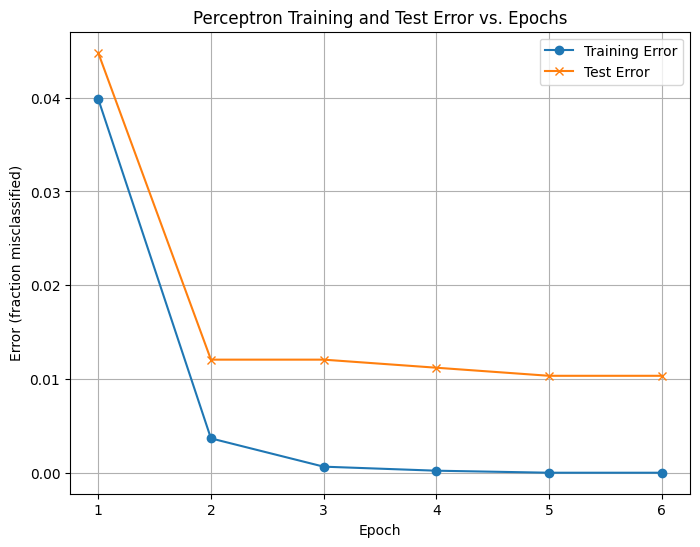

Optimal epoch based on test error: 5
Minimum test error at that epoch: 0.0103
Total mistakes during training: 231
Completed: 6 before Early Stopping.


In [35]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# Train the perceptron.
perceptron = Perceptron(maxEpochs=20)

weights, total, runEpochs = perceptron.fit(
    X_train, y_train,
    X_test=X_test, y_test=y_test
)

trainErrors = perceptron.trainErrors
testErrors = perceptron.testErrors

epochs_axis = np.arange(1, len(trainErrors) + 1)

# Plot the training and test errors vs number of epochs.
plt.figure(figsize=(8, 6))
plt.plot(epochs_axis, trainErrors, label='Training Error', marker='o')
plt.plot(epochs_axis, testErrors, label='Test Error', marker='x')
plt.title("Perceptron Training and Test Error vs. Epochs")
plt.xlabel("Epoch")
plt.ylabel("Error (fraction misclassified)")
plt.legend()
plt.grid(True)
plt.show()

# Find the epoch with the lowest test error
epochIdx = np.argmin(testErrors)
bestEpoch = epochIdx + 1
bestError = testErrors[epochIdx]
print(f"Optimal epoch based on test error: {bestEpoch}")
print(f"Minimum test error at that epoch: {bestError:.4f}")

# Total number of mistakes.
print(f"Total mistakes during training: {total}")
print(f"Completed: {runEpochs} before Early Stopping.")



I chose to run the model for a maximum of 20 epochs, however, it stopped at 6 epochs due to early stopping. The algorithm made 231 mistakes.

The optimal test error was at the 5th epoch, with a value of 0.103.

### (e) Averaged Perceptron Algorithm

In [25]:
import numpy as np

class AveragedPerceptron:
    def __init__(self, maxEpochs):
        # maxEpochs -> the one hyperparameter we set ourselves.
        self.maxEpochs = maxEpochs
        # Initialize weights and bias.
        self.weights = None
        self.bias = None
        # Keeping track of training/test errors.
        self.trainErrors = []
        self.testErrors = []

    def fit(self, X_train, y_train, X_test=None, y_test=None):
        self.trainErrors = []
        self.testErrors = []
        totalMistakes = 0
        _, numFeatures = X_train.shape

        # Convert labels to +1/-1.
        yLabels = np.where(y_train <= 0, -1, 1)

        # Initialize weights and bias to zero.
        w = np.zeros(numFeatures)
        b = 0.0

        # Keep track of running sums.
        wSum = np.zeros(numFeatures)
        bSum = 0.0
        count = 0

        for epoch in range(self.maxEpochs):
            currentMistakes = 0

            # Process each training sample.
            for idx, x_i in enumerate(X_train):
                output = np.dot(w, x_i) + b

                # Predict +1 if output >= 0, else -1.
                prediction = 1 if output >= 0 else -1

                # Update weights and bias for incorrect predictions.
                if yLabels[idx] * prediction <= 0:
                    w += yLabels[idx] * x_i
                    b += yLabels[idx]
                    currentMistakes += 1
                    totalMistakes += 1

                # Calculate the running sums.
                wSum += w
                bSum += b
                count += 1

            # Average weights and bias.
            wAvg = wSum / count
            bAvg = bSum / count

            # Calculate training and test errors.
            trainErr = self.calculate_error(X_train, y_train, wAvg, bAvg)
            self.trainErrors.append(trainErr)

            testErr = self.calculate_error(X_test, y_test, wAvg, bAvg)
            self.testErrors.append(testErr)

            # Early stopping.
            if currentMistakes == 0:
                self.weights = wAvg
                self.bias = bAvg
                return (wAvg, bAvg, totalMistakes, epoch + 1)

        self.weights = wAvg
        self.bias = bAvg
        return (wAvg, bAvg, totalMistakes, self.maxEpochs)

    # Create predictions.
    def predict(self, X):
        output = np.dot(X, self.weights) + self.bias
        return np.where(output >= 0, 1, -1)

    # Calculate error.
    def calculate_error(self, X, y, weightsVec=None, biasVal=None):
        if weightsVec is None:
            weightsVec = self.weights
        if biasVal is None:
            biasVal = self.bias

        y_ = np.where(y <= 0, -1, 1)
        output = np.dot(X, weightsVec) + biasVal
        y_pred = np.where(output >= 0, 1, -1)
        return np.mean(y_pred != y_)


Final averaged weights: [ 0.          0.          2.02204985 ... -0.93747756 -0.99357179
 -4.64634059]
Final averaged bias: 5.15499533146592
Total mistakes: 231
Epochs completed: 6


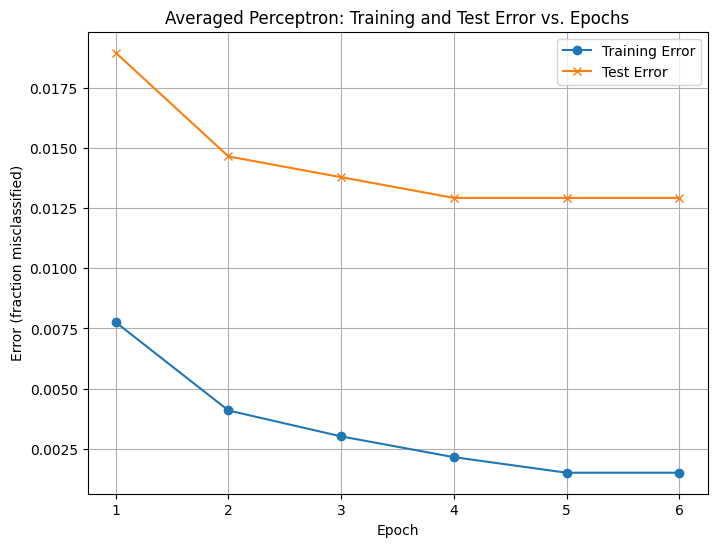

In [26]:
import matplotlib.pyplot as plt

# Train the averaged perceptron.
averagePerceptron = AveragedPerceptron(maxEpochs=20)

wAvg, bAvg, totalMistakes, runEpochs = averagePerceptron.fit(
    X_train, y_train,
    X_test,  y_test
)

print("Final averaged weights:", wAvg)
print("Final averaged bias:", bAvg)
print("Total mistakes:", totalMistakes)
print("Epochs completed:", runEpochs)

# 3) Plot the training & test errors
trainErrors = averagePerceptron.trainErrors
testErrors  = averagePerceptron.testErrors

epochs_axis = range(1, len(trainErrors) + 1)

plt.figure(figsize=(8, 6))
plt.plot(epochs_axis, trainErrors, label="Training Error", marker='o')
if len(testErrors) == len(trainErrors):  # they match in length
    plt.plot(epochs_axis, testErrors, label="Test Error", marker='x')

plt.title("Averaged Perceptron: Training and Test Error vs. Epochs")
plt.xlabel("Epoch")
plt.ylabel("Error (fraction misclassified)")
plt.legend()
plt.grid(True)
plt.show()


As you can see, using an averaged perceptron model results in a more stable graph when compared to the previous implementation.

### (f) The final, or optimal algorithm, is the averaged perceptron due to the greater stability, trained for a maximum of 6 epochs.

In [28]:
p = AveragedPerceptron(maxEpochs=6)
_, _, totalMistakes, runEpochs = p.fit(
    X_train, y_train,
    X_test=X_test, y_test=y_test
)

# Convert y_test to the -1 or +1.
y_converted = np.where(np.array(y_test) <= 0, -1, 1)

y_pred = p.predict(X_test)

print("Total mistakes during training:", totalMistakes)
print("Epochs completed:", runEpochs)
print("Accuracy:", accuracy_score(y_converted, y_pred))
print("\nClassification Report:\n", classification_report(y_converted, y_pred))

Total mistakes during training: 231
Epochs completed: 6
Accuracy: 0.9870801033591732

Classification Report:
               precision    recall  f1-score   support

          -1       0.99      1.00      0.99      1042
           1       0.99      0.88      0.93       119

    accuracy                           0.99      1161
   macro avg       0.99      0.94      0.96      1161
weighted avg       0.99      0.99      0.99      1161



### (g) Vocabulary List

In [29]:
# Build the vocabulary list from the function previously defined.
vocabulary = build_vocabulary(train_data, min_email_count=30)
print(f"Vocabulary size: {len(vocabulary)}")

# Convert training and testing data.
X_train = []
y_train = []
for (cleanedText, label) in train_data:
    X_train.append(email_to_feature_vector(cleanedText, vocabulary))
    y_train.append(label)

X_test = []
y_test = []
for (cleanedText, label) in test_data:
    X_test.append(email_to_feature_vector(cleanedText, vocabulary))
    y_test.append(label)

# Convert to numpy arrays.
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

Vocabulary size: 2608


### (g) Output the 15 words with the most positive weights. And the most negative weights

In [30]:
# Getting the positive and negative indices.
positiveIdx = np.where(weights > 0)[0]
negativeIdx = np.where(weights < 0)[0]

# Sort them by descending order.
sortedIdx = positiveIdx[np.argsort(weights[positiveIdx])[::-1]]
top15 = sortedIdx[:15]

print("Top 15 Words with Highest Positive Weights")
for i in top15:
    print(f"{vocabulary[i]}: {weights[i]:.4f}")

# Top 15 words wityh the most negative weights.
sortedIdx = negativeIdx[np.argsort(weights[negativeIdx])[:15]]
top15 = sortedIdx[np.argsort(weights[sortedIdx])]

print("\nTop 15 Words with Highest Negative Weights")
for i in top15:
    print(f"{vocabulary[i]}: {weights[i]:.4f}")

Top 15 Words with Highest Positive Weights
click: 15.0000
remov: 14.0000
our: 13.0000
money: 11.0000
guarante: 10.0000
will: 10.0000
invest: 9.0000
pay: 9.0000
requir: 9.0000
dear: 9.0000
dollar: 9.0000
repli: 8.0000
purchas: 8.0000
interest: 8.0000
instruct: 8.0000

Top 15 Words with Highest Negative Weights
url: -15.0000
set: -13.0000
issu: -11.0000
inc: -11.0000
them: -10.0000
date: -10.0000
reserv: -10.0000
review: -9.0000
they: -9.0000
wrote: -9.0000
copyright: -9.0000
store: -9.0000
between: -8.0000
had: -8.0000
s: -8.0000
